### 질병 이미지 분류 모델

사과와 옥수수에 대한 질병 분류 모델을 구축한다.

In [1]:
import os
import numpy as np
import splitfolders
import pandas as pd
import tensorflow as tf
import matplotlib as mlp
import matplotlib.pyplot as plt
from glob import glob
from keras import layers, models
from keras.models import load_model
from keras.layers import GlobalAveragePooling2D
from sklearn.metrics import classification_report
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, CSVLogger

### 데이터셋 분할
이미지 데이터셋을 train, test, validation으로 분할한다.

In [16]:
splitfolders.ratio('./cotten_dataset', './my_cotten_data', seed=1337, ratio=(0.7, 0.2, 0.1))

Copying files: 10000 files [00:42, 236.00 files/s]


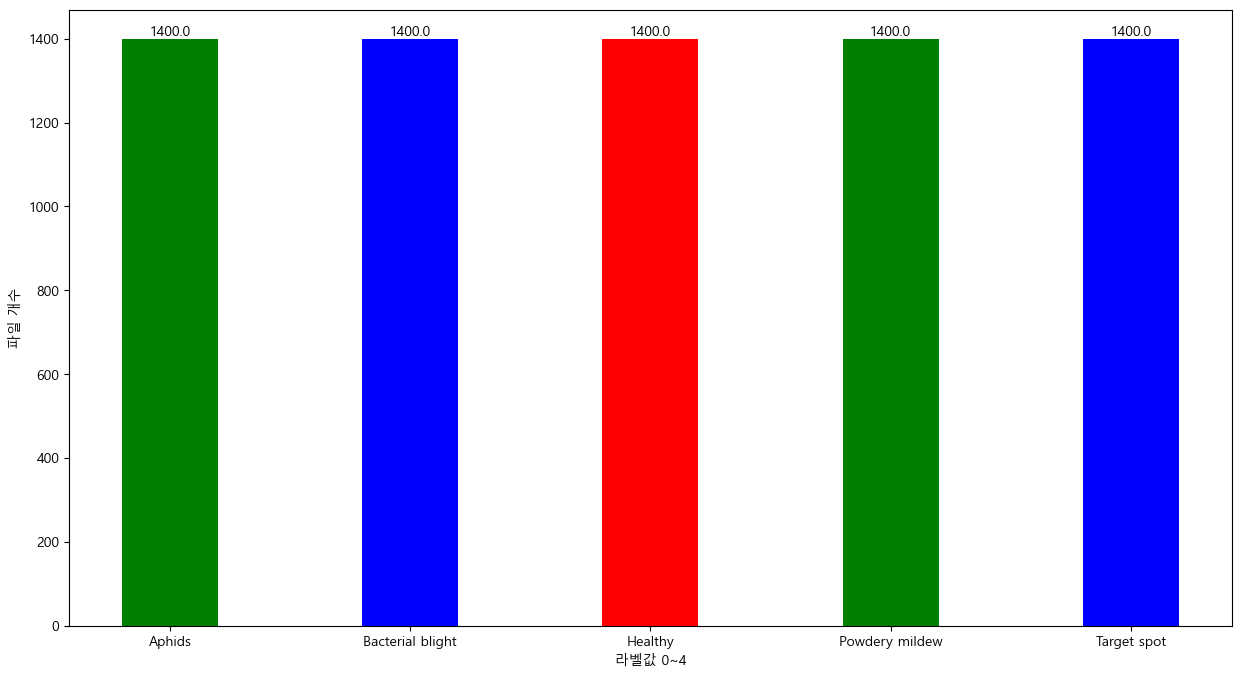

In [17]:
mlp.rcParams["font.family"] = "Malgun Gothic" # 한글 깨짐 방지

train_path = glob("./my_cotten_data/train/*")
file_cnt = [len(os.listdir(path)) for path in train_path] # 파일 개수 리스트화
labels = ['Aphids', 'Bacterial blight', 'Healthy', 'Powdery mildew', 'Target spot']

plt.figure(figsize=(15,8))
bar = plt.bar(labels, file_cnt, width=0.4, color = ["green", "blue", "red"]) # barplot
plt.xlabel("라벨값 0~4")
plt.ylabel("파일 개수")

for rect in bar: # barplot 위에 숫자 표시하기
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width()/2.0, height, '%.1f' % height, ha='center', va='bottom', size = 10)
    
plt.show()

### 학습 파라미터 정의, 데이터 증강

In [2]:
num_epoch = 100
batch_size = 32
learning_rate = 0.001
dropout_rate = 0.3
input_shape = (256, 256, 3)
num_class = 5

In [3]:
train_dir = "./my_cotten_data/train/"
val_dir = "./my_cotten_data/val/"
test_dir = "./my_cotten_data/test/"

train_datagen = ImageDataGenerator(
    rescale=1./255.,
    shear_range=0.2, # 기울이는 정도
    zoom_range=0.2, # 확대하는 정도
)

test_datagen = ImageDataGenerator(
    rescale=1./255.
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size = input_shape[:2],
    batch_size = batch_size,
    color_mode = 'rgb',
    class_mode='categorical'
)

validation_generator = test_datagen.flow_from_directory(
    val_dir,
    target_size=input_shape[:2],
    batch_size=batch_size,
    color_mode='rgb',
    class_mode='categorical'
)

Found 7000 images belonging to 5 classes.
Found 2000 images belonging to 5 classes.


### BaseLine Modeling

In [4]:
# 직접 빌드
def create_my_cnn():
    model = models.Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape = input_shape))
    model.add(layers.MaxPooling2D(2, 2))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D(2, 2))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D(2, 2))
    model.add(layers.Dropout(dropout_rate))
    
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(num_class, activation="softmax")) 

    return model

def fit_my_cnn():
    model = create_my_cnn()
    model.compile(optimizer=tf.optimizers.Adam(learning_rate), loss="categorical_crossentropy", metrics=['acc'])
    model.summary()

    # model_check = ModelCheckpoint(filepath = "./cotten_model/weights/get_anooter_data_split.h5", monitor = "val_acc", save_best_only = True, mode = "max")
    # reduce_lr = ReduceLROnPlateau(monitor = "val_loss", factor = 0.1, patience = 3, mode = "min")
    # early_stop = EarlyStopping(monitor = "val_loss", patience = 5, mode = "min")
    # logger = CSVLogger('./cotten_model/history/get_anooter_data_split.csv')

    # call_back_list = [model_check, logger, early_stop, reduce_lr]

    # model.fit(train_generator, epochs = num_epoch, validation_data = validation_generator, callbacks = call_back_list)

def show_history(history_csv_path):
    mlp.rcParams["font.family"] = "Malgun Gothic"
    mlp.rcParams["axes.unicode_minus"] = False
    
    history = pd.read_csv(history_csv_path)
    plt.figure(figsize=(10,5))

    plt.subplot(1, 2, 1)
    plt.plot(history["epoch"], history['acc'], label="train_accuracy")
    plt.plot(history["epoch"], history['val_acc'], label="valid_accuracy")
    plt.title('모델 정확도')
    plt.xlabel('학습 횟수')
    plt.ylabel("정확도")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history["epoch"], history['loss'], label="train_loss_value")
    plt.plot(history["epoch"], history['val_loss'], label="valid_loss_value")
    plt.title('모델 손실값')
    plt.xlabel('학습 횟수')
    plt.ylabel("손실값")
    plt.legend()
    plt.show()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 64)        36928     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 30, 30, 64)       0

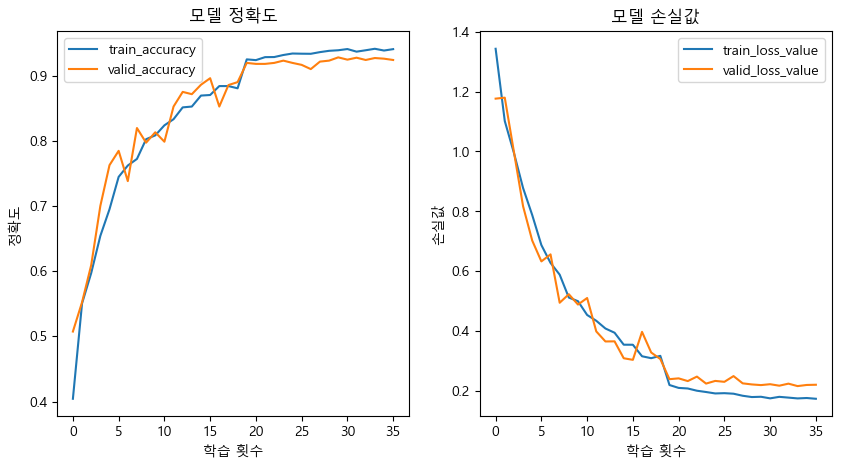

In [5]:
fit_my_cnn()
show_history('./cotten_model/history/get_anooter_data_split.csv')

### 학습 평가

In [25]:
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=input_shape[:2],
    batch_size=batch_size,
    color_mode="rgb",
    class_mode="categorical",
    shuffle = False
)

model = load_model("./cotten_model/weights/GlobalAveragePooling2D-30.h5")
y_true = test_generator.classes

Found 1000 images belonging to 5 classes.


In [26]:
y_pred = []
predictions = model.predict(test_generator, verbose=0)

for predict in predictions:
    y_pred.append(np.argmax(predict))

In [27]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.83      0.90       200
           1       0.85      0.79      0.82       200
           2       0.94      0.98      0.96       200
           3       0.94      0.99      0.97       200
           4       0.81      0.91      0.86       200

    accuracy                           0.90      1000
   macro avg       0.90      0.90      0.90      1000
weighted avg       0.90      0.90      0.90      1000



### 평가 지표 출력
정밀도, 재현율, f1 score를 `classification_report`를 통해 출력한다.

- 평가 지표가 좋은 결과를 주고 있지 않기 때문에 모델을 별도로 수정한다.

In [14]:
input_shape = (224, 224, 3)
batch_size = 16

train_dir = "./cotten_model_data/train/"
test_dir = "./cotten_model_data/val/"

train_datagen = ImageDataGenerator(
    rescale=1./255.,
)

test_datagen = ImageDataGenerator(      
    rescale=1./255.
)

train_generator = train_datagen.flow_from_directory( 
    train_dir,                 
    target_size = input_shape[:2],  
    batch_size = batch_size,
    color_mode = 'rgb',           
    class_mode='categorical'        
)                                   

validation_generator = test_datagen.flow_from_directory(
    test_dir,                      
    target_size=input_shape[:2],    
    batch_size=batch_size,          
    color_mode='rgb',
    class_mode='categorical'        
)

def get_model():
    model = tf.keras.applications.DenseNet201
    params = {
        'input_shape' : input_shape, 
        'include_top': False,
        'weights':'imagenet',
        'pooling':'max',
        'classes':5
    }

    pretrained_model = model(**params)

    for pretrained_layer in pretrained_model.layers:
        pretrained_layer.trainable = False

    inputs = pretrained_model.input

    x = tf.keras.layers.Dense(512)(pretrained_model.output)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation("relu")(x)
    outputs = tf.keras.layers.Dense(5, activation='softmax')(x)
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer=tf.keras.optimizers.Adam(0.001), loss='categorical_crossentropy', metrics=['acc'])

    model_check = ModelCheckpoint(filepath = "./cotten_model/Densenet201/Densenet201-{epoch}.h5", monitor = "val_loss", save_best_only = True, mode = "min")
    reduce_lr = ReduceLROnPlateau(monitor = "val_loss", factor = 0.1, patience = 3, mode = "min")
    early_stop = EarlyStopping(monitor = "val_loss", patience = 5, mode = "min")
    logger = CSVLogger("./cotten_model/Densenet201/history.csv")

    model.fit(
        train_generator, 
        epochs = num_epoch, 
        validation_data = validation_generator, 
        callbacks=[model_check, reduce_lr, early_stop, logger]
    )
    
    

Found 5000 images belonging to 5 classes.
Found 2500 images belonging to 5 classes.


Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d_4 (ZeroPadding2  (None, 230, 230, 3)  0          ['input_4[0][0]']                
 D)                                                                                               
                                                                                                  
 conv1/conv (Conv2D)            (None, 112, 112, 64  9408        ['zero_padding2d_4[0][0]']       
                                )                                                           

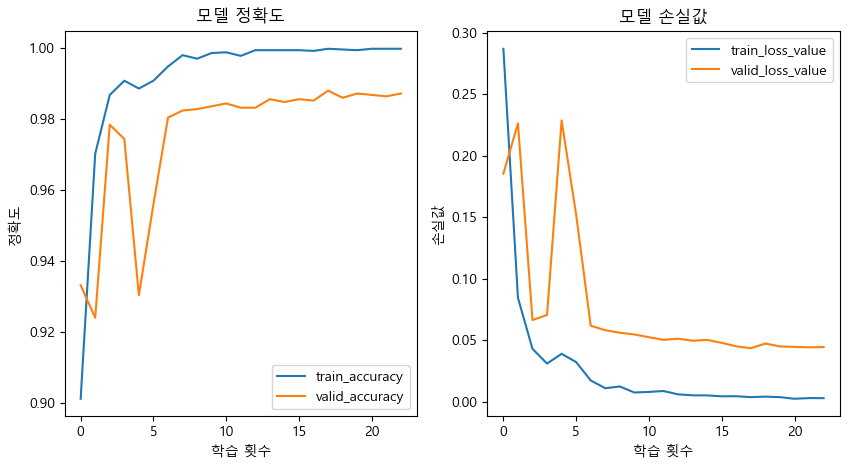

In [15]:
get_model()
show_history('./cotten_model/Densenet201/history.csv')

In [17]:
val_dir = "./cotten_model_data/test/"

val_data = test_datagen.flow_from_directory(
    val_dir,
    target_size=input_shape[:2],    
    batch_size=batch_size,          
    color_mode='rgb',
    class_mode='categorical',
    shuffle=False
)

model = load_model("./cotten_model/Densenet201/Densenet201-18.h5")

y_true = val_data.classes
y_pred = []
for pred in model.predict(val_data):
    y_pred.append(np.argmax(pred))

Found 2500 images belonging to 5 classes.
157/157 [==============================] - 22s 127ms/step


In [18]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.99      0.98       500
           1       0.98      0.98      0.98       500
           2       1.00      1.00      1.00       500
           3       0.99      0.99      0.99       500
           4       0.99      0.98      0.98       500

    accuracy                           0.99      2500
   macro avg       0.99      0.99      0.99      2500
weighted avg       0.99      0.99      0.99      2500

